<a href="https://colab.research.google.com/github/AndreHiratsuka/IA_Unifesp/blob/main/AndreEiki_ThiagoRoberto_ProjetoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some sections of this code are based on the following tutorial provided by TensorFlow: https://www.tensorflow.org/tutorials/images/transfer_learning?hl=pt-br

# <font color=orange> 1. Data Retrieval

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

zf = zipfile.ZipFile('/content/drive/MyDrive/IC_Datasets/BridgeDataset942.zip') # Extracting the dataset from my Google Drive
zf.extractall()
zf.close()

# <font color=orange> 2. Data Storage and Verification

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras

In [ ]:
path = '/content/BridgeDataset942/BridgeDataset'
batch_size = 32
image_size = (160, 160)

In [ ]:
train_dataset = keras.utils.image_dataset_from_directory(path,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=image_size)

Found 2826 files belonging to 3 classes.


In [ ]:
x = np.concatenate([x for x, y in train_dataset], axis=0)
y = np.concatenate([y for x, y in train_dataset], axis=0)

In [ ]:
class_names = train_dataset.class_names
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

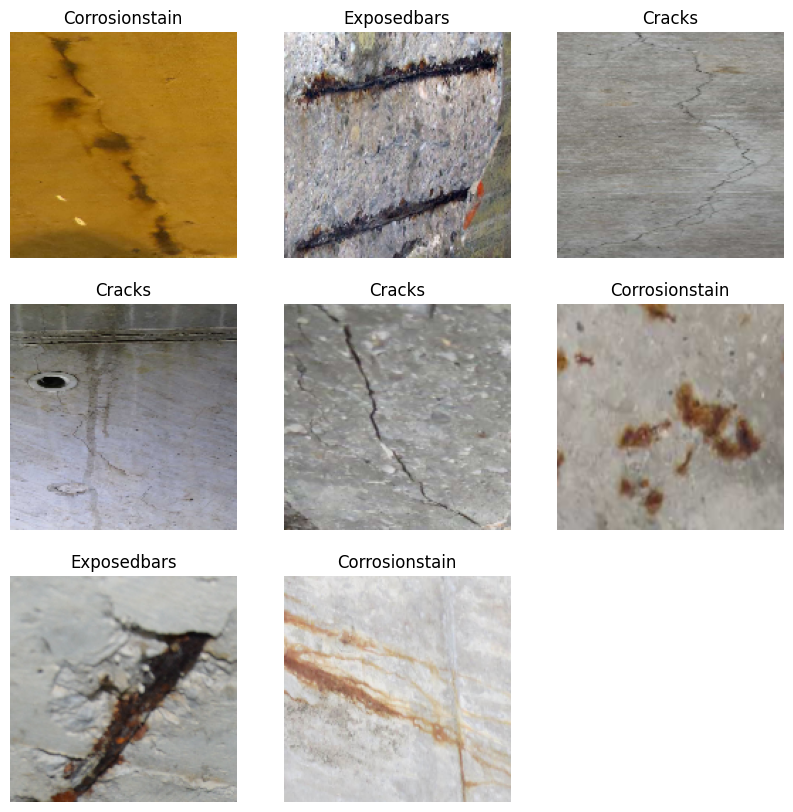

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# <font color=orange> 3. Data Augmentation

In [ ]:
!pip install keras-cv

In [ ]:
import keras_cv
# Performing data augmentation to generate new and consistent data.
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras_cv.layers.preprocessing.Grayscale(),
  keras.layers.GaussianNoise(0.4),
  keras.layers.RandomRotation(0.4),
  keras.layers.RandomContrast(0.3),
  keras.layers.RandomBrightness(0.2, value_range=(0, 255))
])

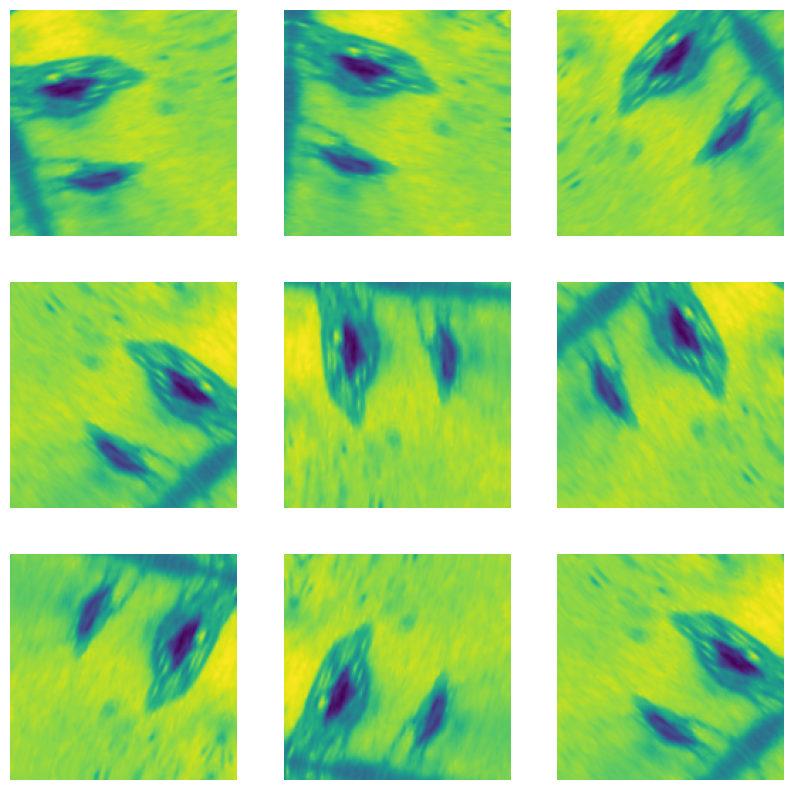

In [ ]:
# Applying the above layers repeatedly on the same image and displaying the result.
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# <font color=orange> 4. Creating the Base Model

> ## <font color=orange> 4.1 Models




> ### <font color=orange> 4.1.1 ResNet101 V2


In [ ]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input # Rescaling the pixel values to range between [-1, 1].

In [ ]:
# Instantiating the ResNet101 V2 model.
input_shape = image_size + (3,)
base_model = keras.applications.ResNet101V2(input_shape=input_shape,
                                            include_top=False)


>### <font color=orange> 4.1.2 MobileNet V2



In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input # Rescaling the pixel values to range between [-1, 1].

In [ ]:
# Instantiating the MobileNet V2 model.
input_shape = image_size + (3,)
base_model = keras.applications.MobileNetV2(input_shape=input_shape,
                                            include_top=False)

9406464/9406464 [==============================] - 0s 0us/step



> ### <font color=orange> 4.1.3 VGG 16



In [ ]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input # Rescaling the pixel values to range between [-1, 1].

In [ ]:
# Instantiating the VGG16 model.
input_shape = image_size + (3,)
base_model = keras.applications.VGG16(input_shape=input_shape,
                                            include_top=False)


>### <font color=orange> 4.1.4 EfficientNet V2 B1



In [ ]:
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input # Rescaling the pixel values to range between [-1, 1].

In [ ]:
# Instantiating the EfficientNet V2 B1 model.
input_shape = image_size + (3,)
base_model = keras.applications.EfficientNetV2B1(input_shape=input_shape,
                                            include_top=False)

>### <font color=orange> 4.1.5 Inception V3

In [ ]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input  # Rescaling the pixel values to range between [-1, 1].

In [ ]:
# Instantiating the Inception V3 model.
input_shape = image_size + (3,)
base_model = keras.applications.InceptionV3(input_shape=input_shape,
                                            include_top=False)

>### <font color=orange> 4.1.6 NASNet Mobile

In [ ]:
preprocess_input = tf.keras.applications.nasnet.preprocess_input  # Rescaling the pixel values to range between [-1, 1].

In [ ]:
# Instantiating the NASNet Mobile model.
input_shape = image_size + (3,)
base_model = keras.applications.NASNetMobile(input_shape=input_shape,
                                            include_top=False)

19993432/19993432 [==============================] - 1s 0us/step


>### <font color=orange> 4.1.7 Xception

In [ ]:
preprocess_input = tf.keras.applications.xception.preprocess_input  # Rescaling the pixel values to range between [-1, 1].

In [ ]:
# Instantiating the Xception model.
input_shape = image_size + (3,)
base_model = keras.applications.Xception(input_shape=input_shape,
                                            include_top=False)

83683744/83683744 [==============================] - 3s 0us/step



> ## <font color=orange> 4.2 Model Settings


In [ ]:
# Convert each 160x160x3 image into a 5x5x1280 feature block.
x_batch, y_batch = next(iter(train_dataset))
feature_batch = base_model(x_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False # Freezing the layers of the base model, preventing their weights from being updated during training.

In [ ]:
global_average_layer = keras.layers.GlobalAveragePooling2D() # Calculating the average of the spatial locations 5x5.
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = keras.layers.Dense(3, activation='softmax')

In [ ]:
inputs = keras.Input(shape=(160, 160, 3))
data = data_augmentation(inputs)
data = tf.image.grayscale_to_rgb(data)
data = preprocess_input(data)
data = base_model(data, training=True)
data = keras.layers.Dropout(0.15)(data)
data = global_average_layer(data)
data = keras.layers.Dropout(0.3)(data)
#data = tf.keras.layers.ActivityRegularization(l1=0.0001)(data)
outputs = prediction_layer(data)
model = keras.Model(inputs, outputs)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150, verbose=1)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 1)       0         
                                                                 
 tf.image.grayscale_to_rgb (  (None, 160, 160, 3)      0         
 TFOpLambda)                                                     
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                             

# <font color=orange> 5. Stratified Cross-validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
import torch

kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11) # Defining the number of parts the dataset will be divided into.

print(kfold)

for i, (train_index, test_index) in enumerate(kfold.split(x, y)):
    print(f"Fold {i+1}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

StratifiedKFold(n_splits=5, random_state=11, shuffle=True)
Fold 1:
  Train: index=[   0    1    3 ... 2822 2823 2824]
  Test:  index=[   2    7    8   15   16   21   22   27   31   35   37   39   43   45
   46   55   56   61   64   73   76   82   94   97  102  114  116  117
  126  133  134  146  150  152  162  164  167  169  173  175  187  188
  195  197  201  202  206  207  209  213  219  225  233  237  254  259
  262  263  264  265  266  267  285  296  298  306  307  309  313  317
  319  323  326  329  332  336  343  349  353  355  363  365  366  370
  376  382  386  396  403  411  414  415  418  420  427  435  447  448
  455  461  473  486  488  489  493  509  511  524  525  528  529  538
  539  541  544  548  549  570  578  582  587  588  590  594  601  603
  604  607  609  613  616  618  623  627  631  632  634  647  668  671
  676  691  692  694  698  701  712  719  720  724  734  756  758  761
  763  764  766  777  782  786  793  795  799  809  812  816  829  832
  835  837  842

In [ ]:
from sklearn import metrics

for i, (train_index, test_index) in enumerate(kfold.split(x, y)):
    print(f"\nFold {i+1}:")

    X_train = x[train_index]
    Y_train = y[train_index]

    X_test = x[test_index]
    Y_test = y[test_index]

    # Training with the frozen layers for feature extraction.
    initial_epochs = 30
    base_learning_rate = 0.0001

    base_model.trainable = False

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    history = model.fit(X_train, Y_train,
                        epochs=initial_epochs,
                        validation_split=0.2,
                        callbacks=[callback])

    # Training with the unfrozen layers for fine-tuning the network.
    base_model.trainable = True

    fine_tune_at = 100

    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False

    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer = keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

    fine_tune_epochs = 600
    total_epochs =  initial_epochs + fine_tune_epochs

    history_fine = model.fit(X_train, Y_train,
                            epochs=total_epochs,
                            initial_epoch=history.epoch[-1]+1,
                            validation_split = 0.2,
                            callbacks=[callback])

    # Testing the model.
    predictions1 = model.predict(X_test)
    predictions2 = np.argmax(predictions1, axis=1)
    print(f'Loss: {metrics.log_loss(Y_test, predictions1):.4f}')
    print(f'Accuracy: {metrics.accuracy_score(Y_test, predictions2):.4f}')


Fold 1:
Epoch 1/2
57/57 [==============================] - 10s 90ms/step - loss: 1.4731 - accuracy: 0.3186 - val_loss: 1.2739 - val_accuracy: 0.2765
Epoch 2/2
57/57 [==============================] - 2s 36ms/step - loss: 1.3141 - accuracy: 0.3529 - val_loss: 1.2505 - val_accuracy: 0.3119
Epoch 3/4
57/57 [==============================] - 16s 72ms/step - loss: 1.3122 - accuracy: 0.3518 - val_loss: 1.2402 - val_accuracy: 0.3208
Epoch 4/4
18/18 [==============================] - 2s 54ms/step
Loss: 1.1958
Accuracy: 0.3339

Fold 2:
Epoch 1/2
57/57 [==============================] - 9s 80ms/step - loss: 1.3377 - accuracy: 0.3512 - val_loss: 1.2236 - val_accuracy: 0.3400
Epoch 2/2
57/57 [==============================] - 3s 47ms/step - loss: 1.2496 - accuracy: 0.3601 - val_loss: 1.2103 - val_accuracy: 0.3311
Epoch 3/4
57/57 [==============================] - 15s 72ms/step - loss: 1.1759 - accuracy: 0.3861 - val_loss: 1.1608 - val_accuracy: 0.3488
Epoch 4/4
18/18 [============================

# <font color=orange> 6. Training the Model Without Cross-validation


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

> ## <font color=orange> 6.1 Feature Extraction

In [ ]:
initial_epochs = 30
loss0, accuracy0 = model.evaluate(x_train, y_train)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

71/71 [==============================] - 2s 34ms/step - loss: 1.0683 - accuracy: 0.4261
initial loss: 1.07
initial accuracy: 0.43


In [ ]:
history = model.fit(x_train, y_train,
                    epochs=initial_epochs,
                    validation_split = 0.2,
                    callbacks=[callback])

57/57 [==============================] - 3s 59ms/step - loss: 1.0854 - accuracy: 0.4187 - val_loss: 1.0979 - val_accuracy: 0.4115


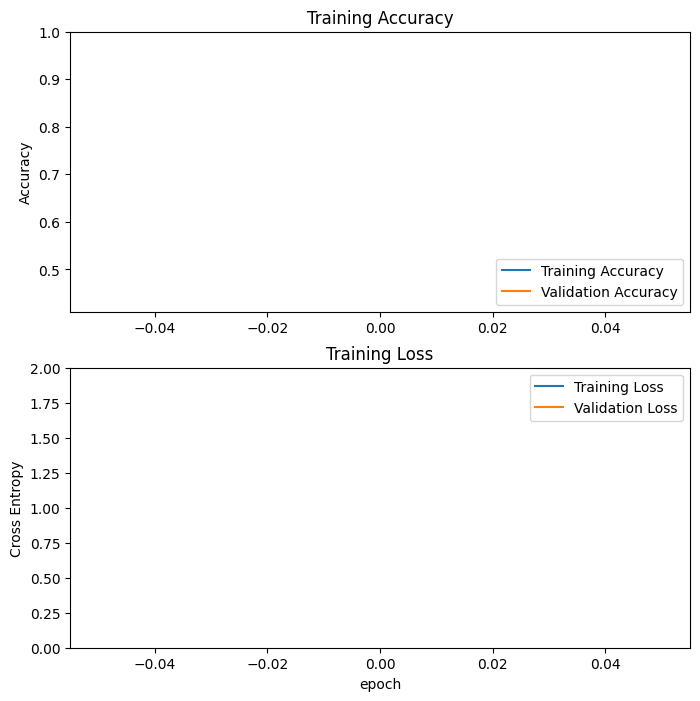

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

> ## <font color=orange> 6.2 Fine-tuning


In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer = keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 1)       0         
                                                                 
 tf.image.grayscale_to_rgb (  (None, 160, 160, 3)      0         
 TFOpLambda)                                                     
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                             

In [ ]:
fine_tune_epochs = 600
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(x_train, y_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1]+1,
                         validation_split= 0.2,
                         callbacks=[callback])

Epoch 2/2
57/57 [==============================] - 15s 72ms/step - loss: 1.0656 - accuracy: 0.4513 - val_loss: 1.0948 - val_accuracy: 0.3960


> ## <font color=orange> 6.3 Result Analysis

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

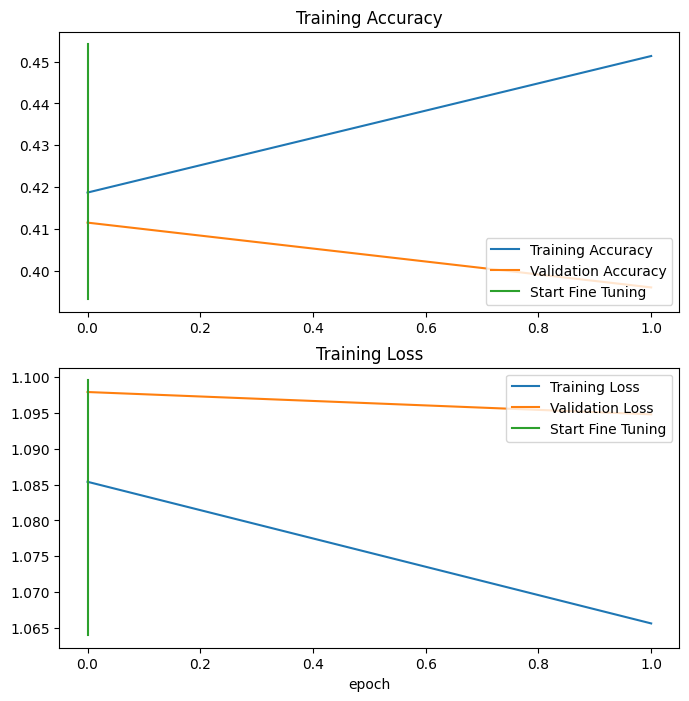

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

18/18 [==============================] - 1s 31ms/step - loss: 1.0860 - accuracy: 0.4258
Test accuracy : 0.4257950484752655
Test loss : 1.086017370223999


In [ ]:
import sklearn.metrics

predictions = model.predict(x_train)
predictions = np.argmax(predictions, axis=1)

y_true = y_train
y_pred = predictions

print('Precision: {:.2f}'.format(sklearn.metrics.precision_score(y_true, y_pred, average='micro')))
print('Recall: {:.2f}'.format(sklearn.metrics.recall_score(y_true, y_pred, average='micro')))
print('f1-score: {:.2f}'.format(sklearn.metrics.f1_score(y_true, y_pred, average='micro')))

71/71 [==============================] - 3s 24ms/step
Precision: 0.46
Recall: 0.46
f1-score: 0.46


18/18 [==============================] - 0s 23ms/step
Predictions:
 [1 2 1 2 1 2 2 1 1 1 2 1 1 0 1 0 0 0 2 2 2 1 1 2 2 0 0 0 2 0 2 1 0 0 2 1 2
 0 1 1 2 1 1 1 1 0 1 0 2 0 0 1 1 0 2 0 2 2 2 1 2 0 1 1 2 1 1 2 1 2 0 2 0 1
 1 1 0 2 0 2 0 1 0 0 1 2 0 0 0 2 2 2 2 0 1 0 2 0 0 0 2 1 1 1 0 2 0 2 0 0 1
 2 1 2 1 1 0 2 0 2 0 2 2 0 1 2 2 1 2 2 1 2 0 1 2 1 0 0 1 2 2 2 2 1 2 1 0 0
 0 1 2 0 1 0 0 1 1 1 2 1 1 0 1 1 0 1 1 2 2 1 2 1 2 1 0 2 1 0 1 0 1 0 0 2 2
 0 0 0 1 1 1 2 2 2 1 1 1 2 2 1 1 2 2 0 2 1 2 0 2 1 0 1 1 1 0 0 0 1 0 0 1 0
 1 1 2 2 0 1 2 0 1 2 1 1 0 1 2 0 2 0 2 0 1 2 0 1 1 1 2 0 0 1 1 1 1 2 2 1 2
 0 1 2 0 1 0 1 1 1 2 1 1 0 0 2 1 2 1 1 0 2 0 1 2 2 1 0 2 0 0 0 1 2 1 2 0 1
 0 2 0 2 1 1 0 0 0 2 1 1 2 0 1 1 0 2 0 1 2 0 0 0 2 0 2 0 2 2 0 1 0 1 2 1 0
 1 1 0 1 0 1 1 0 0 1 2 2 0 1 2 2 2 2 2 2 2 1 0 1 2 0 1 2 0 0 1 0 1 0 0 2 1
 2 2 1 1 0 2 2 0 1 2 1 1 1 1 1 0 1 1 2 2 0 2 2 0 0 0 1 1 0 0 2 0 1 1 0 2 1
 2 2 1 2 1 0 2 0 0 0 0 0 2 2 2 1 1 1 2 0 0 1 1 0 1 0 0 2 1 1 2 2 0 0 1 2 1
 0 0 0 2 1 2 0 0 2 0 2 2 1 1 2 2

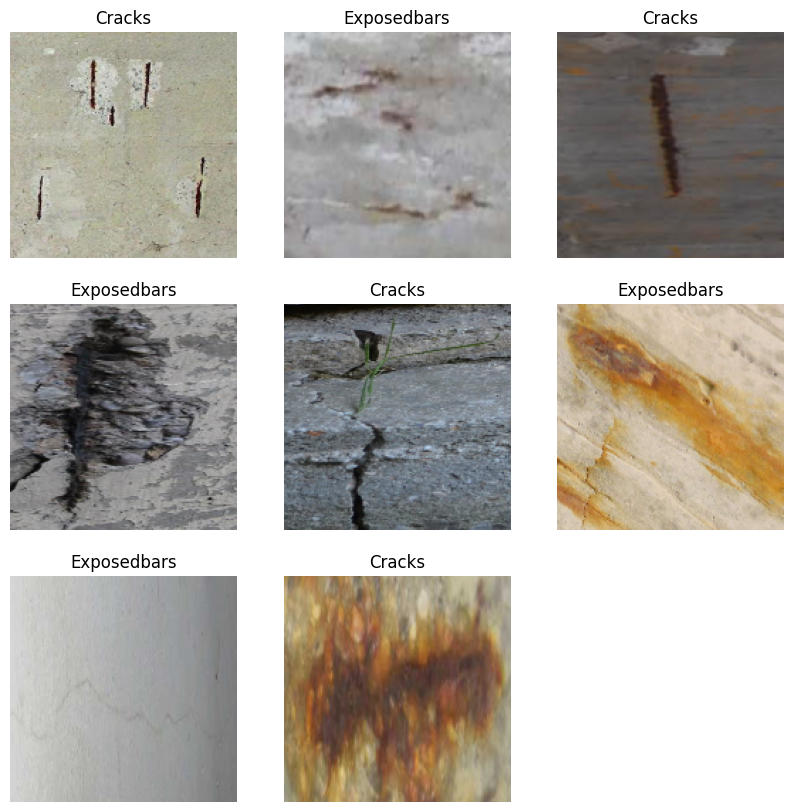

In [ ]:
x_batch, y_batch = x_test, y_test
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)

print('Predictions:\n', predictions)
print('Labels:\n', y_test)

plt.figure(figsize=(10, 10))
for i in range(8):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(x_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

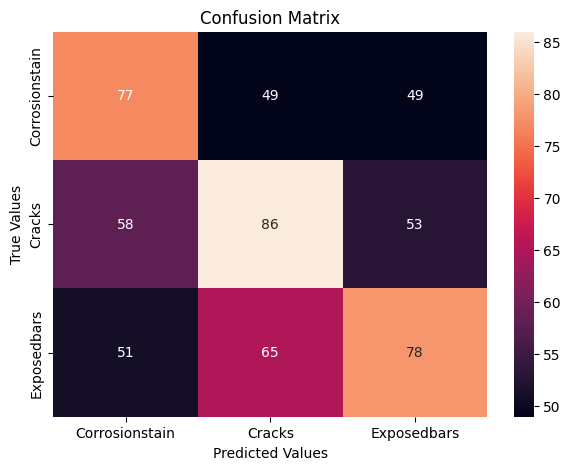

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

y_true = y_test
y_pred = predictions

cf_matrix = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cf_matrix,
                     index = ['Corrosionstain','Cracks','Exposedbars'],
                     columns = ['Corrosionstain','Cracks','Exposedbars'])

plt.figure(figsize=(7,5))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
model.save('model.h5') # Saving the model